# Aula 6 - DBSCAN

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) DBSCAN
- 2) Aplicação - clusterização de estações

In [ ]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

____
____
_____

## 1) DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma vantagem enorme é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

Vamos entender o funcionamento do algoritmo mais a fundo!

O DBSCAN tem como princípio fundamental a **determinação de regiões de alta densidade de observações**, que são **separadas entre si por regiões de baixa densidade**.

Lembrando que, por ser um algoritmo não-supervisionado de clusterização, quando nos referimos à "regiões" cuja densidade será aferida, estamos nos referindo a regiões **do espaço de features**.

Uma pergunta natural é: **como determinar a densidade de uma região?** Para responder esta pergunta, precisamos de algumas definições:

> **Densidade em um ponto $P$:** número de pontos dentro de um círculo de raio $\epsilon$ centrado no ponto $P$ (região chamada de vizinhança-$\epsilon$ de $P$);

> **Região densa**: dizemos que uma região é densa se o círculo de raio $\epsilon$ contém pelo menos um número mínimo de pontos (que chamaremos de $\text{minPts}$. Uma região densa **formará um cluster**.

Para visualizar as definições acima, considere a figura a seguir:

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontos centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
>Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados - muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;<br><br>
>Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.<br><br>
>Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.<br><br>
>Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).



__________

Agora que entendemos os princípios e principais hiperparâmetros do DBSCAN, vamos agora entender os passos do algoritmo (que é bem simples!)

> **Passo 1**: o algoritmo escolhe aleatoriamente um dos pontos, e sua vizinhança-$\epsilon$ é calculada;

> **Passo 2**: se este ponto tem $\text{minPts}$ em sua vizinhança-$\epsilon$, a formação do cluster é iniciada (veja próximo passo). Se não, o ponto é marcado como outlier (mas pode ser considerado como border point de um outro cluster posteriormente). Se for um outlier, volte ao passo 1;

> **Passo 3**: se o ponto for um core point, todos os pontos na vizinhança são agregados ao cluster, e o passo 1 é aplicado a cada um deles;

> **Passo 4**: o processo do passo 3 é continuado até que todos os pontos tenham um cluster associado ou esteja marcado como noise.

Podemos visualizar a seguir o DBSCAN em funcionamento:


<img src="http://data-analysis-stats.jp/wp-content/uploads/2019/09/DBSCAN_01.gif" width=400>
  

<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


A classe do sklearn é esta: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


____


## 2) Aplicação - clusterização de estações

Vamos pegar os dados geográficos das estações da malha de transporte metropolitano de SP, e ver uma aplicação interessante do DBSCAN

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("../datasets/metroetrem_sp_comlinks.csv").reset_index(drop=True)

In [6]:
df.head()

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46723768,-23586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46708157,-23571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46701610,-23567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46694102,-23567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46684259,-23566228,FRADIQUE COUTINHO,OSCAR FREIRE


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   num_lin      196 non-null    int64 
 1   nome_lin     196 non-null    object
 2   long         196 non-null    int64 
 3   lat          196 non-null    int64 
 4   estacao_upp  196 non-null    object
 5   link         196 non-null    object
dtypes: int64(3), object(3)
memory usage: 9.3+ KB


In [8]:
df['long'] = df['long']/1e6
df['lat'] = df['lat']/1e6

df.head()

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46.723768,-23.586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46.708157,-23.571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46.701610,-23.567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46.694102,-23.567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46.684259,-23.566228,FRADIQUE COUTINHO,OSCAR FREIRE


In [9]:
df.describe()

,num_lin,long,lat
count,196.000000,196.000000,196.000000
mean,6.897959,-46.627699,-23.550003
std,4.026807,0.141381,0.082085
min,1.000000,-46.983711,-23.743306
25%,3.000000,-46.705265,-23.595562
50%,7.000000,-46.638983,-23.545068
75%,10.000000,-46.557528,-23.525365
max,15.000000,-46.184967,-23.195382


In [10]:
df['nome_lin'].value_counts()

AZUL         23
DIAMANTE     22
RUBI         19
ESMERALDA    18
VERMELHA     18
LILAS        17
CORAL        16
VERDE        14
SAFIRA       13
TURQUESA     13
AMARELA      10
PRATA        10
JADE          3
Name: nome_lin, dtype: int64

In [11]:
colors = {'AMARELA': '#f0d20e',
          'AZUL': '#0515a3',
          'CORAL': '#e07000',
          'DIAMANTE': '#919190',
          'ESMERALDA': '#0bd6a3',
          'JADE': '#0bd637',
          'LILAS': '#a659de',
          'PRATA': '#616161',
          'RUBI': '#9c2438',
          'SAFIRA': '#0c0880',
          'TURQUESA': '#267587',
          'VERDE': '#048a37',
          'VERMELHA': '#d10202'}

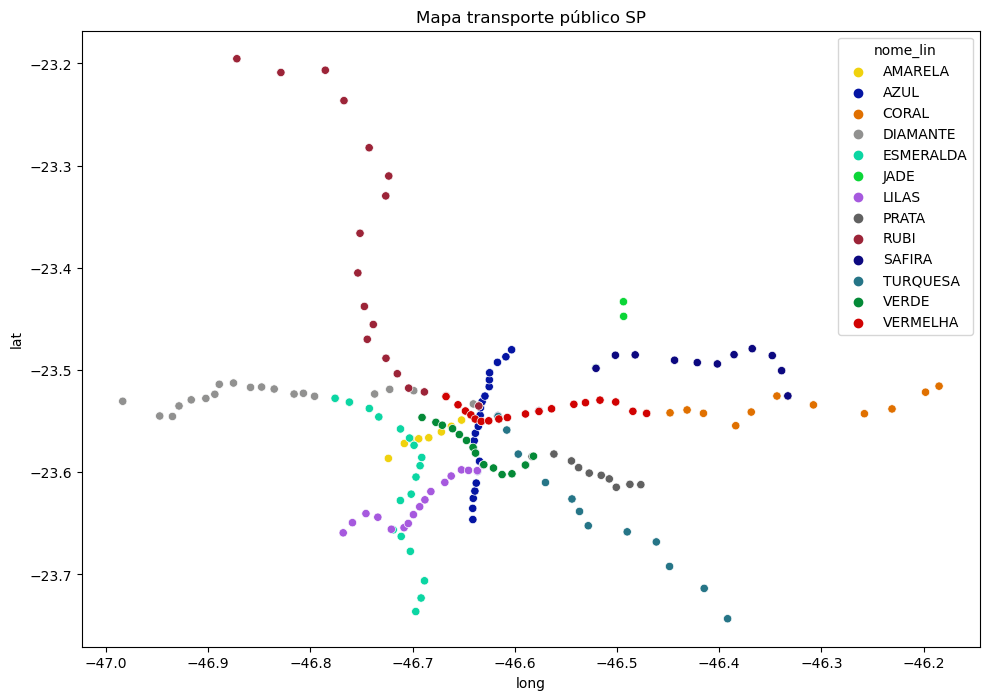

In [14]:
plt.figure(figsize=(16, 8))

plt.title('Mapa transporte público SP')

sns.scatterplot(data=df, x='long', y='lat', hue='nome_lin', palette=colors)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

<img src="https://i.redd.it/6jxo08iuzpxy.gif" width=500>

In [15]:
X = df[['lat', 'long']]

In [16]:
X = np.radians(X)

In [17]:
X

,lat,long
0,-0.411661,-0.815484
1,-0.411407,-0.815211
2,-0.411329,-0.815097
3,-0.411326,-0.814966
4,-0.411308,-0.814794
...,...,...
191,-0.410709,-0.812118
192,-0.410666,-0.811870
193,-0.410697,-0.811602
194,-0.410857,-0.811309


In [18]:
from sklearn.cluster import DBSCAN

In [19]:
eps_km = 4
RT = 6371.0088

eps_angular = eps_km/RT

In [20]:
dbscan = DBSCAN(eps=eps_angular, min_samples=2, metric='haversine')
dbscan.fit(X)

DBSCAN(eps=0.0006278440550890465, metric='haversine', min_samples=2)

In [21]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1,  3,  3,  4,  4,  4, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [23]:
X['clusters_dbscan'] = dbscan.labels_
X

,lat,long,clusters_dbscan
0,-0.411661,-0.815484,0
1,-0.411407,-0.815211,0
2,-0.411329,-0.815097,0
3,-0.411326,-0.814966,0
4,-0.411308,-0.814794,0
...,...,...,...
191,-0.410709,-0.812118,0
192,-0.410666,-0.811870,0
193,-0.410697,-0.811602,0
194,-0.410857,-0.811309,0


In [25]:
X['clusters_dbscan'].nunique()

6

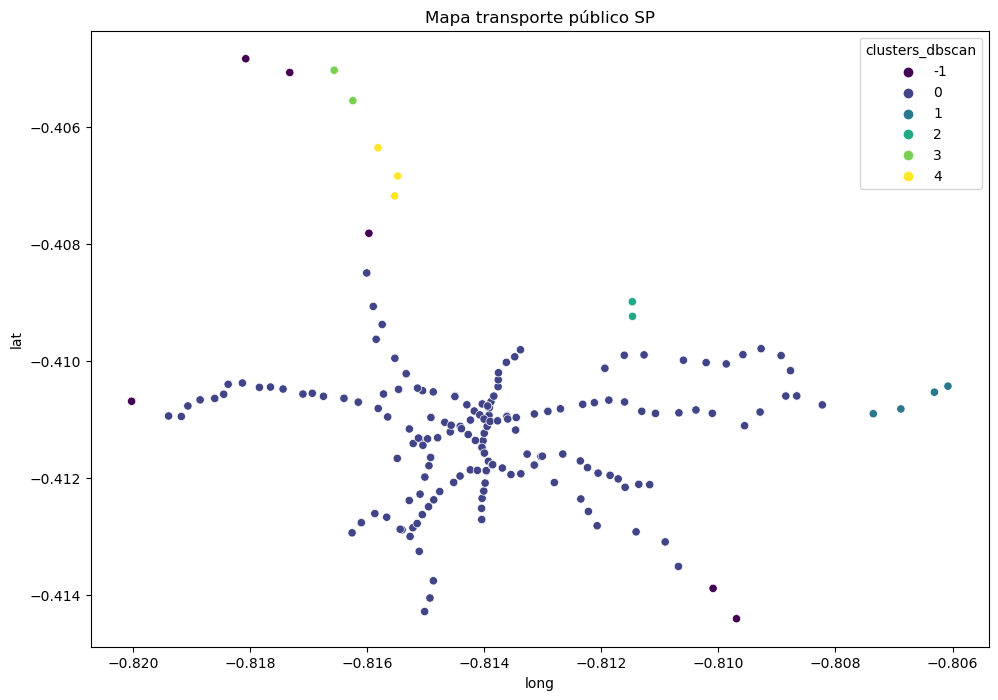

In [28]:
plt.figure(figsize=(16, 8))

plt.title('Mapa transporte público SP')

sns.scatterplot(data=X, x='long', y='lat', hue='clusters_dbscan', palette='viridis')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [30]:
df.loc[X[X['clusters_dbscan'] == -1].index]

,num_lin,nome_lin,long,lat,estacao_upp,link
49,8,DIAMANTE,-46.983711,-23.530541,AMADOR BUENO,SANTA RITA
119,7,RUBI,-46.872035,-23.195382,JUNDIAI,VARZEA PAULISTA
120,7,RUBI,-46.828941,-23.208851,VARZEA PAULISTA,CAMPO LIMPO PAULISTA
126,7,RUBI,-46.751528,-23.366166,CAIEIRAS,PERUS
162,10,TURQUESA,-46.414767,-23.713632,ANTONIO BESPALEC RIBEIRAO PIRES,RIO GRANDE DA SERRA
163,10,TURQUESA,-46.391864,-23.743306,RIO GRANDE DA SERRA,RIO GRANDE DA SERRA


Vamos usar a [distância de Haversine](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

Importante: primeiro ponto é a latitude, segundo é a longitude!

Comparando com o k-means...

In [31]:
X_kmeans = X.copy()

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_kmeans)

c:\Users\Bruno Scale\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Bruno Scale\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4)

In [38]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
X_kmeans['cluster_kmeans'] = kmeans.labels_
X_kmeans.head()

,lat,long,clusters_dbscan,cluster_kmeans
0,-0.411661,-0.815484,0,0
1,-0.411407,-0.815211,0,0
2,-0.411329,-0.815097,0,0
3,-0.411326,-0.814966,0,0
4,-0.411308,-0.814794,0,0


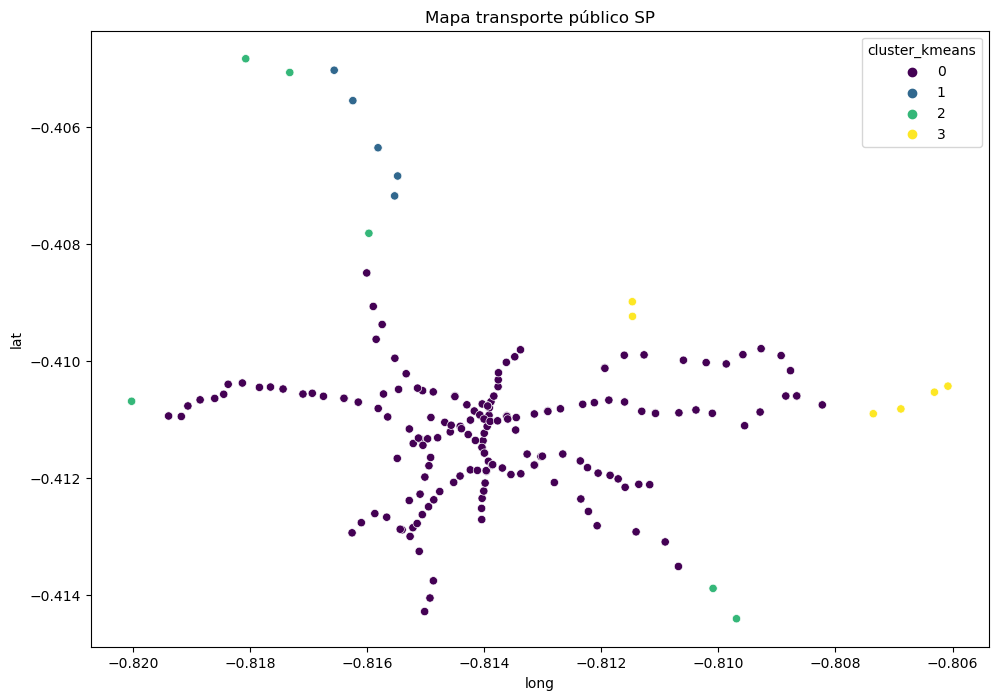

In [40]:
# Criar o gráfico para o k-means
plt.figure(figsize=(16, 8))

plt.title('Mapa transporte público SP')

sns.scatterplot(data=X_kmeans, x='long', y='lat', hue='cluster_kmeans', palette='viridis')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Bora praticar?

A partir do código disponibilizado abaixo, cujo objetivo é gerar uma amostra de 1.000 observações com duas features, treine os modelos de K-Means e DBSCAN aprendidos até a aula de hoje. Faça um gráfico para demonstrar os agrupamentos realizados em ambos os casos.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# geracao dos dados
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=1000, n_features=2, centers=5, random_state=42)
df = pd.DataFrame(X, columns = ['x1', 'x2'])
plt.scatter(X[:,0], X[:,1])

plt.show()

**DBSCAN**

**K-Means**

**Comparação entre os modelos**

## Mini tarefa

Usando o famoso dataset iris sem a variável target, que se encontra na pasta datasets com nome `iris_unsupervised.csv`, treine um modelo DBSCAN com raio de 0.4 e mínimo de amostras de 3. A partir disso responda no [forms](https://forms.gle/6LSLiv6aZojBxBr7A) quantas classes o algoritmo encontrou (incluindo a classe -1 equivalente aos outliers).